# pbh

> A module to model and calculate the properties of primordial black holes (PBHs), such as density, mass, distance, and velocity distribution.

In [ ]:
#| default_exp pbh

In [18]:
#| hide
from nbdev.showdoc import *

In [19]:
#| export
from LensCalcPy.parameters import *
from LensCalcPy.utils import *
from LensCalcPy.lens import *
from LensCalcPy.galaxy import *

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad, dblquad
from scipy.interpolate import interp1d, interp2d
from tqdm import tqdm
# from multiprocessing import Pool
from pathos.multiprocessing import ProcessingPool as Pool
import functools
import pickle
from abc import ABC, abstractmethod

from fastcore.test import *

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
#| export
class Pbh(Lens):
    """A class to represent a PBH population"""

    def __init__(self,
                mass: float, # PBH mass in solar masses
                f_dm: float, # PBH fraction of the DM density
                mw_model=None,
                m31_model=None,
                l = None,
                b = None,
                u_t = 1,
                ds = 770,
                ):
        """
        Initialize the PBH population
        """

        self.mw_model = mw_model or MilkyWayModel(mw_parameters)
        self.m31_model = m31_model or M31Model(m31_parameters)
        
        if l is None:
            raise ValueError("Galactic longitude must be specified")
        if b is None:
            raise ValueError("Galactic latitude must be specified")
        self.l = l
        self.b = b

        if mass < m_low_interp or mass > m_high_interp:
            raise ValueError("PBH mass must be between 1e-16 and 1e-4 or a different interpolation function must be used for u_t")
        self.mass = mass
        if f_dm < 0 or f_dm > 1:
            raise ValueError("f_dm must be between 0 and 1")
        self.f_dm = f_dm
        # self.ut_interp = ut_interp
        self.ut_interp = ut_func_new
        self.u_t = u_t
        self.ds = ds
    
    def __str__(self) -> str:
        return f"PBH population with mass={self.mass} and f_dm={self.f_dm}"
    __repr__ = __str__

    def differential_rate_integrand_mw(self, umin, d, t, finite=False):
        return self.differential_rate_integrand(umin, d, t, dist_mw, density_mw, velocity_dispersion_mw, finite=finite)
    
    def differential_rate_integrand_m31(self, umin, d, t, finite=False):
        return self.differential_rate_integrand(umin, d, t, dist_m31, density_m31, velocity_dispersion_m31, finite=finite)

    def differential_rate_mw(self, t, finite=False):
        return self.differential_rate(t, self.differential_rate_integrand_mw, finite=finite)

    def differential_rate_m31(self, t, finite=False):
        return self.differential_rate(t, self.differential_rate_integrand_m31, finite=finite)

    def umin_upper_bound(self, d):
        # return self.ut_interp(d, self.mass)[0]
        rho = rho_func(self.mass, d, self.ds)
        return self.ut_interp(rho, magnification(self.u_t))
    
    def differential_rate_total(self, t, finite=False):
        return self.differential_rate_mw(t, finite=finite) + self.differential_rate_m31(t, finite=finite)
 
    def compute_differential_rate(self, ts, finite=False):
        return [self.differential_rate_total(t, finite=finite) for t in ts]

In [22]:
m_lens = 1e-8
pbh = Pbh(m_lens, 1, l=l, b=b, ds=ds)
ts = np.logspace(-2,1,50)

In [23]:
#test object creation
test_eq(pbh.mass, m_lens)

#test differential rate
test_eq(pbh.differential_rate_total(1), pbh.differential_rate_mw(1) + pbh.differential_rate_m31(1))

#test that threshold parameter is close to 1 for small d
test_close(pbh.umin_upper_bound(0), 1, eps=1e-2)

#test that threshold parameter is close to 0 when close to source
test_close(pbh.umin_upper_bound(ds*0.99), 0, eps=1e-2)

#test that umin lower bound is correctly inherited from Lens
test_eq(pbh.umin_lower_bound(0), 0)

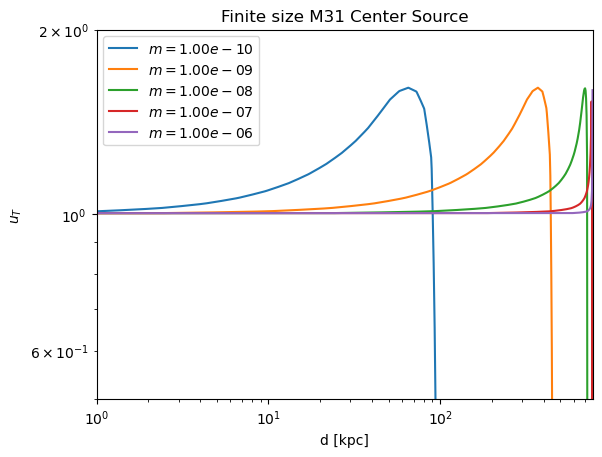

In [25]:
d_arr = np.logspace(0, np.log10(ds*0.999), 1000)

m_pbh_arr = np.logspace(-10, -6, 5)

rhos_calc = [[rho_func(m, d, ds) for d in d_arr] for m in m_pbh_arr]

for m, rhos in zip(m_pbh_arr, rhos_calc):
    plt.plot(d_arr, ut_func_new(rhos, 1.34), label=f"$m= {m:.2e}$")

plt.xscale("log")
plt.yscale("log")
plt.xlim(min(d_arr), max(d_arr))
plt.ylim(5e-1, 2)

plt.xlabel("d [kpc]")
plt.ylabel("$u_{T}$")
plt.title("Finite size M31 Center Source")

plt.legend()
plt.show()

In [26]:
result_mw = [pbh.differential_rate_mw(t, finite=False) for t in ts]
result_m31 = [pbh.differential_rate_m31(t, finite=False) for t in ts]

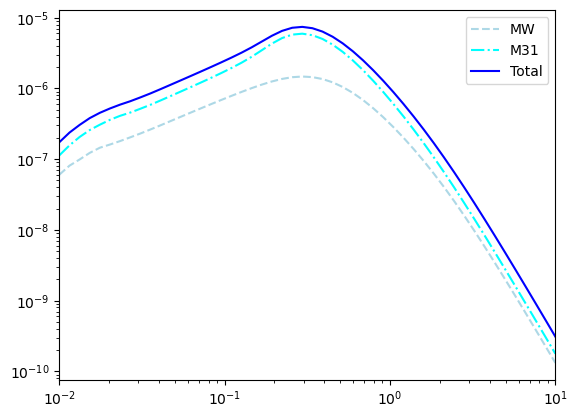

In [27]:
plt.loglog(ts, result_mw, label="MW", color="lightblue", linestyle="--")
plt.loglog(ts, result_m31, label="M31", color="cyan", linestyle="-.")
plt.loglog(ts, np.array(result_mw) + np.array(result_m31), label="Total", color="blue")
plt.xlim(1e-2, 1e1)
# plt.ylim(1e-8, 1e-5)
plt.legend()
plt.show()

In [22]:
result_mw_finite = [pbh.differential_rate_mw(t, finite=True) for t in ts]
result_m31_finite = [pbh.differential_rate_m31(t, finite=True) for t in ts]

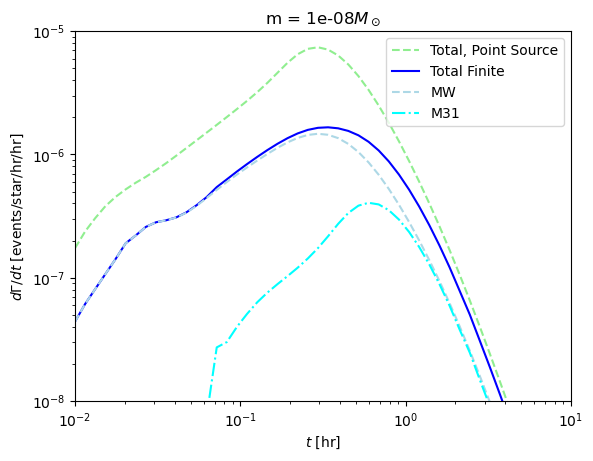

In [23]:
plt.loglog(ts, np.array(result_mw) + np.array(result_m31), label="Total, Point Source", color="lightgreen", linestyle="--")
plt.loglog(ts, np.array(result_mw_finite) + np.array(result_m31_finite), label="Total Finite", color="blue")
plt.loglog(ts, result_mw_finite, label="MW", color="lightblue", linestyle="--")
plt.loglog(ts, result_m31_finite, label="M31", color="cyan", linestyle="-.")
plt.xlim(1e-2, 1e1)
plt.ylim(1e-8, 1e-5)
plt.xlabel(r"$t$ [hr]")
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
plt.title("m = {}".format(pbh.mass) + r"$M_\odot$")
plt.legend()
plt.show()

In [24]:
ts = np.logspace(-2, 3, 100)
pbhs = [Pbh(10**(i), 1, l=l, b=b) for i in np.linspace(-5, -3, 3)]

result = np.zeros((len(pbhs), len(ts)))
for i, pbh in enumerate(pbhs):
    result[i] = pbh.compute_differential_rate(ts, finite=False)

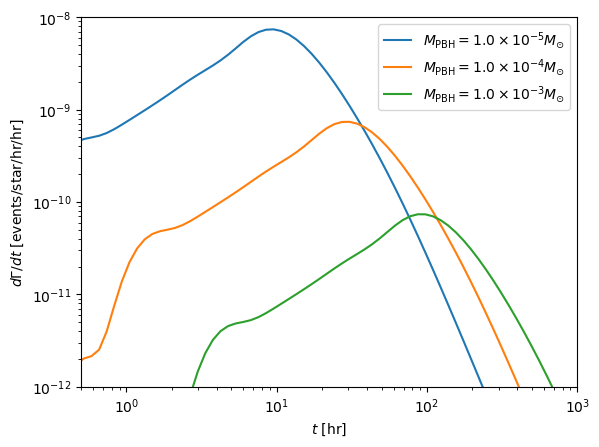

In [25]:
for i, pbh in enumerate(pbhs):
    plt.loglog(ts, result[i], label=r"$M_{\rm{PBH}} = $" + scientific_format(pbh.mass,0) + "$M_{\odot}$")

plt.xlabel(r"$t$ [hr]")
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]")
plt.xlim(5e-1, 1e3)
plt.ylim(1e-12, 1e-8)

plt.legend()
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()